# Support Vector Regression for Rogue Wave Prediction

***Model motivation and approach***

In this notebook, we predict rogue wave characteristics using a Support Vector Machine (SVM) regressor. SVMs are flexible supervised learning models capable of capturing both linear and nonlinear relationships through their choice of kernel function. Their margin-based optimization makes them robust to outliers, while the ε-insensitive loss focuses model capacity on deviations that matter, helping prevent overfitting in noisy or weakly structured datasets. These properties make SVMs a useful complement to tree-based and linear methods when modelling subtle or highly nonlinear dependencies in oceanographic data.

***Data preprocessing***

Because SVMs are sensitive to the scale of input variables, all features are standardized using `StandardScaler`. Scaling ensures that the RBF kernel behaves consistently across dimensions and improves optimization stability and generalization.

***Model Training***

Hyperparameter optimization is performed using stratified k-fold cross-validation to maintain proportional representation of rare rogue-wave events in all folds. This improves stability and comparability across validation splits.

We tune the following hyperparameters:

- **kernel = ['rbf']**  
  The RBF kernel models complex nonlinear relationships and is the most appropriate choice for this dataset.

- **C = [0.1, 1]**  
  Regularization strength balancing margin width and training fit. Smaller values of C encourage wider margins (more regularization), while larger values allow the model to fit the training data more closely.

- **gamma = [0.01, 0.1, 1]**  
  Controls the influence radius of support vectors; lower values offer smoother decision functions.

- **epsilon = [0.01, 0.1, 0.2]**  
  Defines the margin of tolerance within which prediction errors are not penalized.

Training a full SVM on a million samples is computationally expensive. To make the model feasible, we use **ThunderSVM**, which enables efficient GPU-accelerated training. A limitation is that inference also requires access to GPU memory, as the model retains a very large number of support vectors.


***Model Evaluation***

To assess predictive performance, we compute:

- **MSE** — sensitive to large errors  
- **MAE** — robust average deviation  
- **R² score** — explained variance  
- **Spearman correlation** — preserves rank information even when relationships are not strictly linear  

Together, these metrics provide a comprehensive view of model accuracy and stability.


***Model Interpretation***

We use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model. SHAP values provide:

- **Global feature importance** — which variables the model relies on most  
- **Local explanations** — how individual features contribute to a specific prediction  
- **Interaction insights** — how combinations of features influence model behaviour  

To interpret the SVM’s predictions, we apply SHAP using the model-agnostic `KernelExplainer`. Unlike linear or tree-based SHAP explainers, `KernelExplainer` approximates Shapley values by fitting local surrogate models around each prediction and integrating over a background dataset. This makes it suitable for black-box models whose internal structure is not directly accessible. We use a background sample of **200 randomly selected waves** and compute SHAP values.

SHAP values are computed for:

- **160,000 training waves**  
- **40,000 test waves**

Training-set SHAP values reflect learned dependencies, while test-set values show how well these dependencies generalize. Comparing both sets helps identify overfitting and highlights which features consistently drive predictions across unseen data.

***Conclusion***

The SVM model provides strong predictive performance for estimating the Abnormality Index, achieving high R² and Spearman correlations on both the training and test sets. Although performance on the training data is slightly higher, the modest reduction on the test set indicates that the model generalizes well despite its substantial complexity. A defining characteristic of this model is its extremely large number of support vectors (359,574 in total) which reflects the difficulty of separating the data with a smooth nonlinear boundary and highlights the computational and memory demands of kernel-based methods at this scale.

SHAP analysis shows that the SVM distributes importance broadly across features rather than concentrating influence on a few dominant variables. Air temperature, hourly pressure change, atmospheric pressure, kh, and significant wave height appear as the most influential predictors, but their contributions differ only marginally. This diffuse importance pattern is consistent with the nature of RBF kernels, which often draw on many local relationships rather than forming strong global dependencies. The beeswarm plot further illustrates the overlap among features, suggesting that the SVM relies on a wide combination of subtle signals rather than sharp discriminative structures.

Partial dependence patterns reinforce this interpretation: most features show weak, smooth, and nonlinear relationships with the predicted abnormality, without clear thresholds or dominant effects. Instead of identifying a handful of decisive physical drivers, the model captures a finely textured combination of influences spread across the feature space.

Overall, while the SVM achieves accurate predictions and successfully models complex nonlinear behaviour in rogue-wave abnormality, its reliance on more than 350,000 support vectors limits its practicality and interpretability. Compared with tree-based models, the SVM offers less clarity in feature importance and substantially higher computational cost, making it less suitable for large-scale operational forecasting despite its strong predictive performance.

**Imports**

In [1]:
import os
import sys
import pickle
import shap

import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.svm import SVR
# from sklearn.preprocessing import StandardScaler


sys.path.append('./')
sys.path.append('../scripts/')
import utils

**Parameter Settings**

In [2]:
# n_jobs = 4
# print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

In [3]:
# seed = 42
# num_cv = 5

In [ ]:
# hyperparameter_grid = {
#     'kernel': ['rbf'],  
#     'C': [0.1, 1],  
#     'gamma': [0.01, 0.1, 1],  
#     'epsilon': [0.01, 0.1, 0.2]  
# }

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [5]:
# file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
# data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

**Data Standardization**

In [6]:
# scaler = StandardScaler()
# X_train_transformed = scaler.fit_transform(X_train)
# X_test_transformed = scaler.transform(X_test)

**Model Training**

In [7]:
# Run CV
# regressor = SVR()
# model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train, n_jobs, verbose=2)

In [8]:
# we run the svm model on GPU using a script and load the cross-validation results here
# python run_svm_regression.py
cv_results = pd.read_csv("../results/svm/cv_results.csv", index_col=0)  

In [9]:
cv_results.sort_values(by="score", ascending=False, inplace=True)
cv_results

,C,epsilon,gamma,kernel,score
11,1.0,0.01,1.00,rbf,0.931051
2,0.1,0.01,1.00,rbf,0.881896
14,1.0,0.10,1.00,rbf,0.832365
5,0.1,0.10,1.00,rbf,0.784952
10,1.0,0.01,0.10,rbf,0.591583
13,1.0,0.10,0.10,rbf,0.581524
17,1.0,0.20,1.00,rbf,0.503129
8,0.1,0.20,1.00,rbf,0.477185
4,0.1,0.10,0.10,rbf,0.423817
1,0.1,0.01,0.10,rbf,0.421543


In [10]:
# Load model and data
model, _, _, _, _, _, _ = utils.load_data_and_model("../results/svm/model_and_data.pickle", output=False)

In [11]:
print("Number of support vectors:", len(model.support_))

Number of support vectors: 394916


In [12]:
# Load and unpack the train and test predictions
with open("../results/svm/performance_train.pickle", "rb") as handle:
    performance_train = pickle.load(handle)

y_true_train, y_pred_train, mse_train, mae_train, r2_train, spearman_r_train = performance_train

with open("../results/svm/performance_test.pickle", "rb") as handle:
    performance_test = pickle.load(handle)

y_true_test, y_pred_test, mse_test, mae_test, r2_test, spearman_r_test = performance_test

**Model Evaluation**

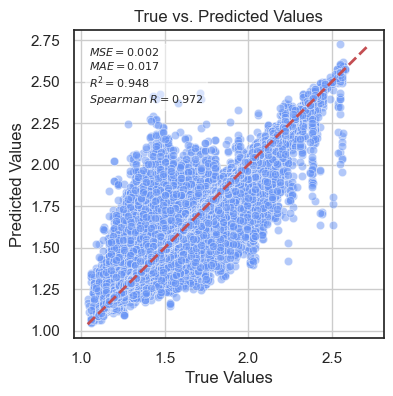

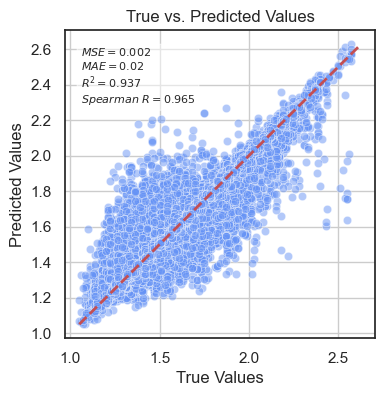

In [13]:
# Evaluate model on train and test set
utils.plot_predictions(y_true_train, y_pred_train, textstr = f"$MSE={mse_train}$\n$MAE={mae_train}$\n$R^2={r2_train}$\n$Spearman\\ R={spearman_r_train}$")
utils.plot_predictions(y_true_test, y_pred_test, textstr = f"$MSE={mse_test}$\n$MAE={mae_test}$\n$R^2={r2_test}$\n$Spearman\\ R={spearman_r_test}$")

Model specifications from model training:

The support vector machine (SVM) model was trained using a high-performance computing environment equipped with NVIDIA H100 80 GB GPUs. Training was executed on a GPU node, which hosts eight H100 GPUs configured with three MIG (Multi-Instance GPU) partitions, alongside an Intel Xeon Platinum 8480+ processor (224 cores / 448 threads) and 2 TB of system memory. The SLURM job configuration allocated one GPU and 200 GB of RAM. Cross-validation required a total of 172.64 minutes of compute time. The final trained SVM model occupies 0.1734 GB on disk.

**Model Interpretation**

Interpretation on Training Set

In [ ]:
file_shap = f"../results/svm/train_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_train = pickle.load(handle)

In [ ]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for SVM - Training Set")
plt.show()

In [ ]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for SVM - Training Set")
plt.show()

In [ ]:
utils.plot_shap_dependence(explanation_train)

Interpretation on Test Set

In [15]:
file_shap = f"../results/svm/test_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_test = pickle.load(handle)

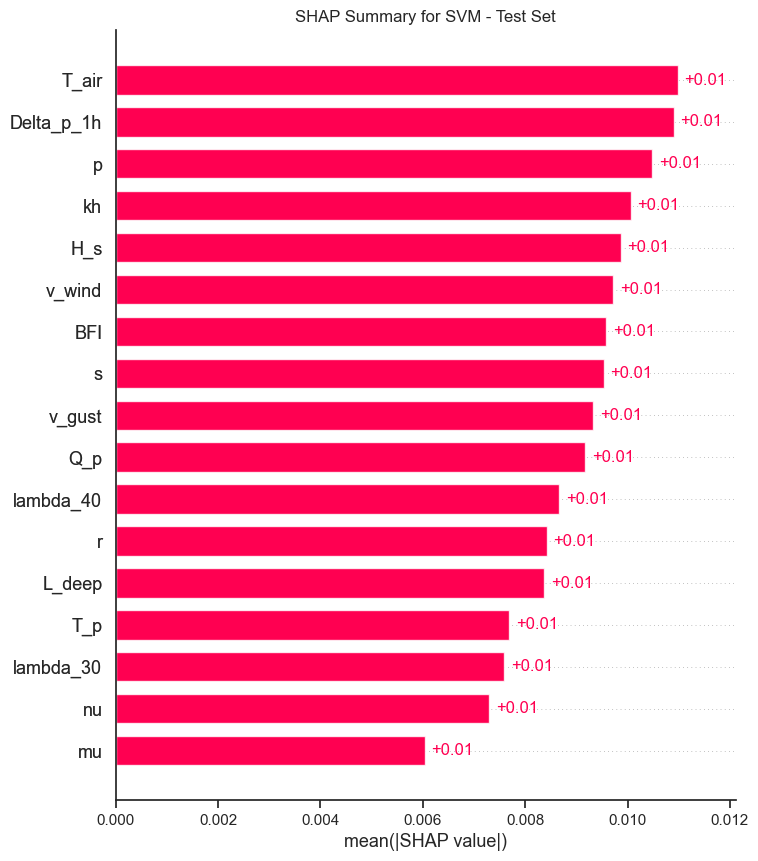

In [16]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for SVM - Test Set")
plt.show()

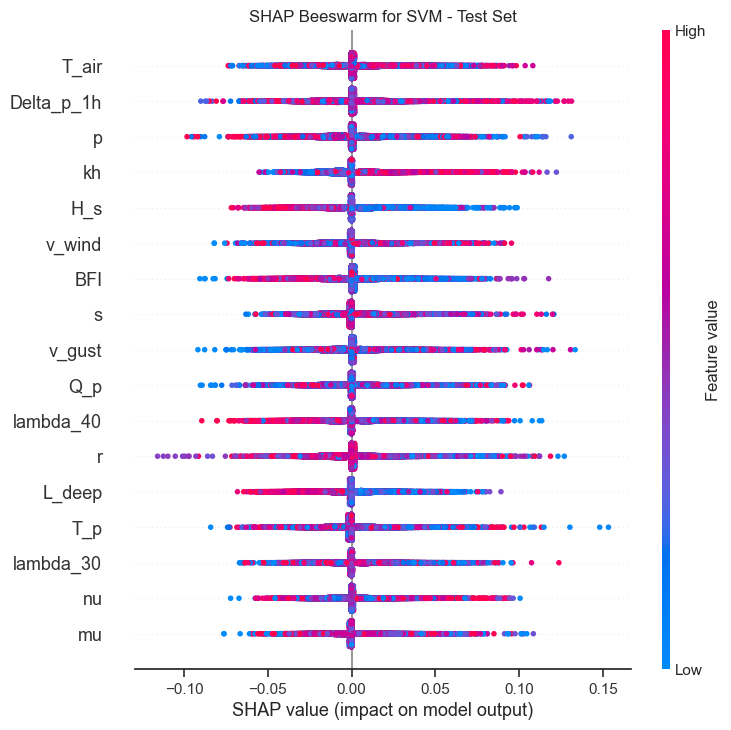

In [17]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for SVM - Test Set")
plt.show()

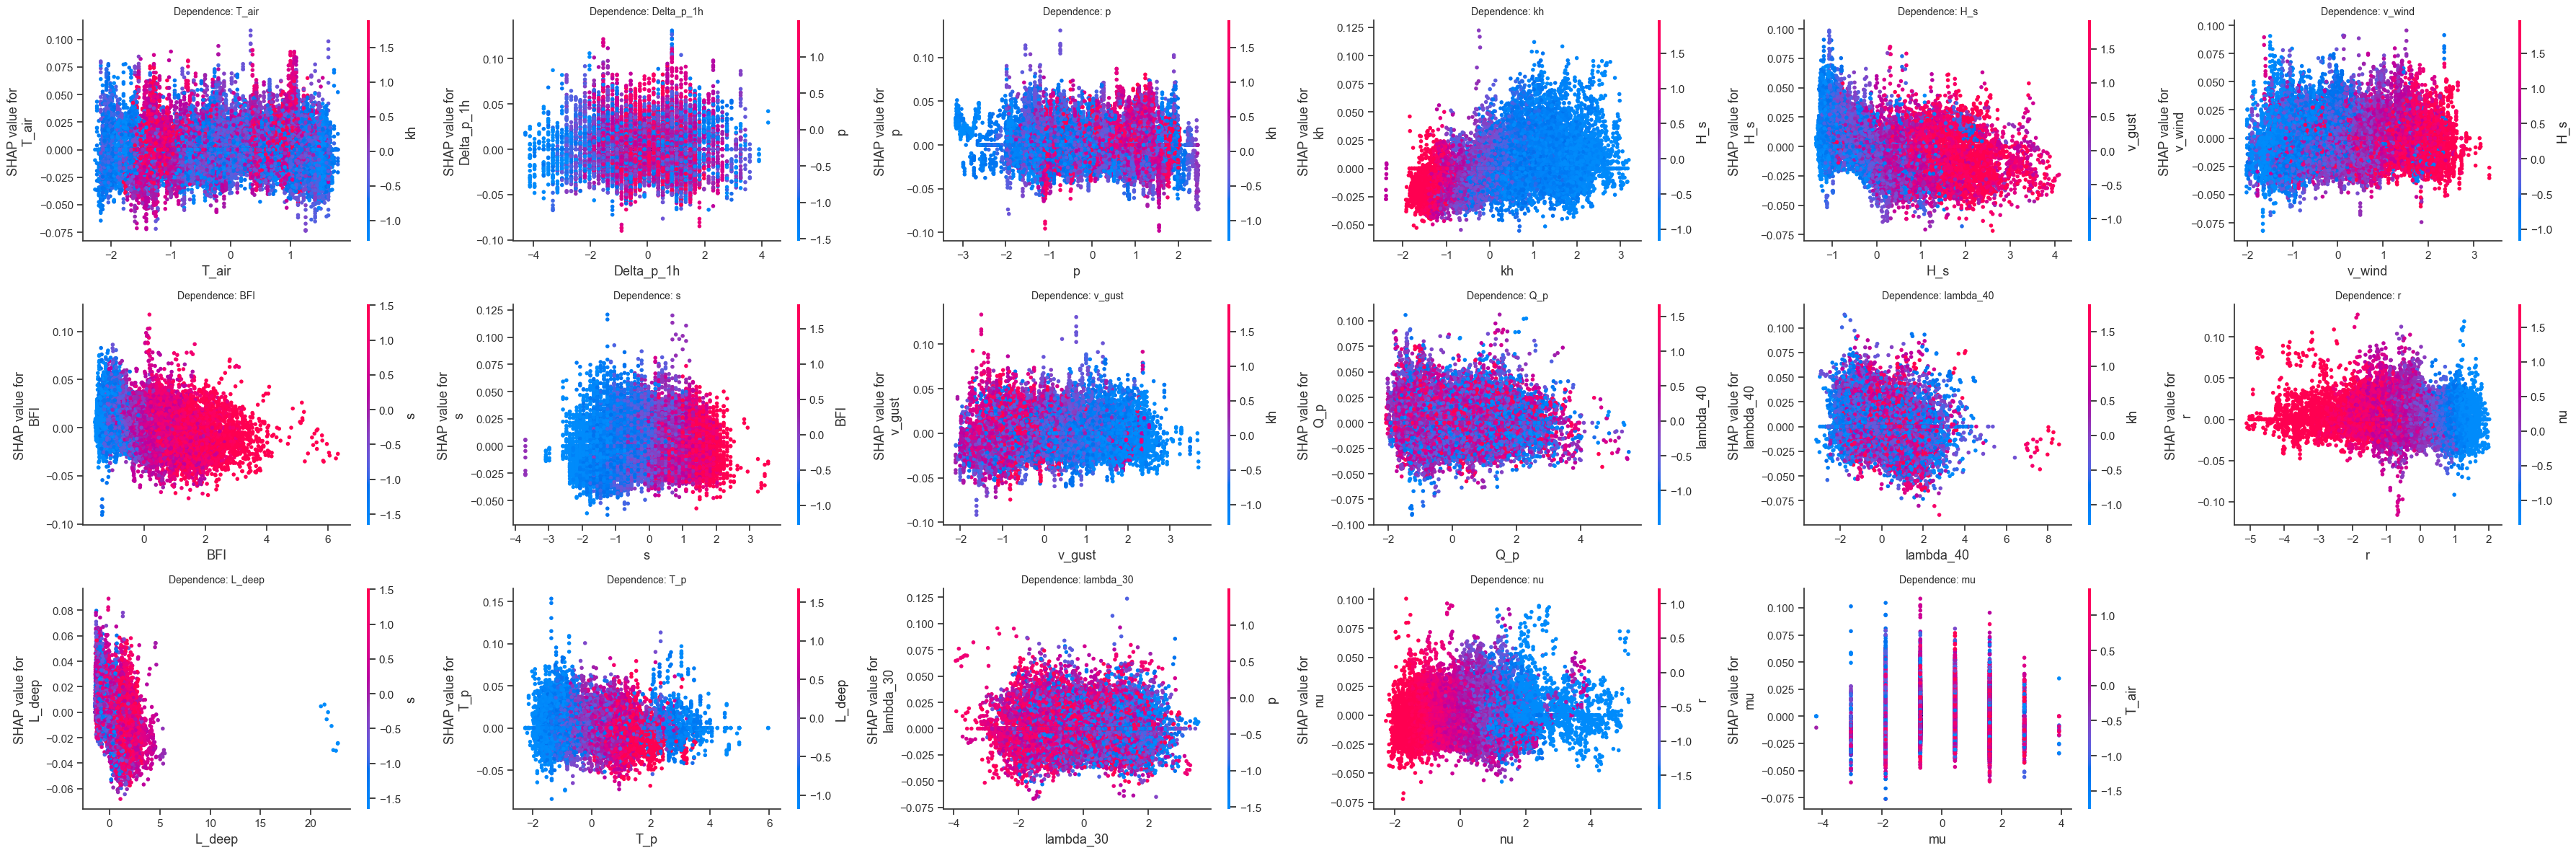

In [18]:
utils.plot_shap_dependence(explanation_test)